In [1]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
#|default_exp agents.dqn.dueling

In [4]:
#|export
# Python native modules
import os
from collections import deque
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
from torchdata.dataloader2.graph import find_dps,traverse,DataPipe,replace_dp,remove_dp
# Local modules
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *

from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.data.block import *
from fastrl.memory.experience_replay import *
from fastrl.agents.core import *
from fastrl.agents.discrete import *
from fastrl.loggers.core import *
from fastrl.loggers.jupyter_visualizers import *
from fastrl.learner.core import *
from fastrl.agents.dqn.basic import *
from fastrl.agents.dqn.target import *

# DQN Dueling
> DQN using a split head for comparing the davantage of different actions



## Training DataPipes

In [9]:
#|export
class DuelingHead(nn.Module):
    def __init__(self,
            hidden:int, # Input into the DuelingHead, likely a hidden layer input
            n_actions:int, # Number/dim of actions to output
            lin_cls=nn.Linear
        ):
        super().__init__()
        self.val=lin_cls(hidden,1)
        self.adv=lin_cls(hidden,n_actions)

    def forward(self,xi):
        val,adv=self.val(xi),self.adv(xi)
        xi=val.expand_as(adv)+(adv-adv.mean()).squeeze(0)
        return xi

Try training with basic defaults...

In [10]:
from fastrl.envs.gym import *
from fastrl.agents.dqn.target import *
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2,head_layer=DuelingHead) #.cuda()
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=4000)#,device='cuda')
# Setup the DataBlock
block = DataBlock(
    blocks = GymTransformBlock(agent=agent,nsteps=1,nskips=1,firstlast=False)
)
# pipes = L(block.datapipes(['CartPole-v1']*1,n=10))
dls = L(block.dataloaders(['CartPole-v1']*1,n=1000,bs=1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=100_000,
                    dp_augmentation_fns=[
                        TargetModelUpdater.insert_dp(),
                        TargetModelQCalc.replace_dp()
                    ])
# learner.fit(3)
learner.fit(25)

loss,episode,rolling_reward,epoch,batch,epsilon
0.011206978,49,20.687500,1,1000,0.749500
0.0666285,90,21.696629,2,1000,0.499250
0.0872794,109,27.760000,3,1000,0.249000
0.07766913,119,34.180000,4,1000,0.020000
0.45359045,125,42.920000,5,1000,0.020000
0.6983808,128,51.790000,6,1000,0.020000
0.27220464,131,59.430000,7,1000,0.020000
0.63157344,135,71.350000,8,1000,0.020000
1.6977825,138,81.350000,9,1000,0.020000
1.307195,141,89.880000,10,1000,0.020000


The DQN learners, but I wonder if we can get it to learn faster...

In [11]:
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2,head_layer=DuelingHead)
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=10000)
# Setup the DataBlock
block = DataBlock(
    blocks = GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True) # We basically merge 2 steps into 1 and skip. 
)
# pipes = L(block.datapipes(['CartPole-v1']*1,n=10))
dls = L(block.dataloaders(['CartPole-v1']*1,n=1000,bs=1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=20_000,nsteps=2,lr=0.001,
                    dp_augmentation_fns=[
                        TargetModelUpdater.insert_dp(),
                        TargetModelQCalc.replace_dp()
                    ])
# learner.fit(3)
learner.fit(10)

loss,episode,rolling_reward,epoch,batch,epsilon
0.20146126,79,25.840000,1,1000,0.811300
2.507037,121,42.760000,2,1000,0.617300
4.709148,143,65.940000,3,1000,0.420300
8.5995245,156,94.940000,4,1000,0.222200
9.315621,164,127.300000,5,1000,0.023100
9.030329,172,153.980000,6,1000,0.020000
10.423734,181,185.540000,7,1000,0.020000
16.758791,188,211.040000,8,1000,0.020000
6.50301,196,230.680000,9,1000,0.020000
14.011031,205,244.200000,9,1000,0.020000


In [12]:
from fastrl.loggers.jupyter_visualizers import *

In [13]:
model.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
    (2): DuelingHead(
      (val): Linear(in_features=512, out_features=1, bias=True)
      (adv): Linear(in_features=512, out_features=2, bias=True)
    )
  )
)

In [14]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.envs.gym import GymTypeTransform,GymStepper

def gym_pipe_base(envs,total_steps,seed=0):
    pipe = dp.map.Mapper(envs)
    pipe = TypeTransformLoop(pipe,[GymTypeTransform])
    pipe = dp.iter.MapToIterConverter(pipe)
    pipe = dp.iter.InMemoryCacheHolder(pipe)
    pipe = pipe.cycle(count=total_steps)
    pipe = GymStepper(pipe,agent=agent,seed=seed,include_images=True)
    return pipe

In [15]:
%matplotlib inline

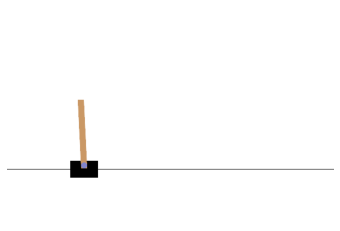

In [16]:

video_logger = SimpleJupyterVideoPlayer()

pipe = gym_pipe_base(['CartPole-v1'],1000,seed=None)
pipe = ImageCollector(pipe,[video_logger])

pipe = video_logger.connect_source_datapipe(pipe)

for o in pipe:pass

In [18]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()